In [1]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_data_new" #change the path to your dataset folder here

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=42)
 
    #we want to use a 15% validation split
    vsplit = int(len(images) * 0.20)
    train = images[:-vsplit]
    val = images[-vsplit:]
 
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
 
    return classes, train, val
 
#parse dataset
CLASSES, TRAIN, VAL = parseDataset()


CLASS LABELS: ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
TRAINING IMAGES: 86155
VALIDATION IMAGES: 21538


In [2]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [3]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_dense1, num_filters=64, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_dense2 = layers.DenseLayer(l_dense1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense1,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=7, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 1738759 PARAMS


In [4]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [5]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [6]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0002)

In [7]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [8]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    #img = np.transpose(img, (2, 0, 1))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((7), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 7)
 
    return img, target

In [9]:
#a reasonable size for one batch is 128
BATCH_SIZE = 200
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 7), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

START TRAINING...
EPOCH: 1
TRAIN LOSS: 1.5630889542502835
VAL LOSS: 0.5737379079504875
VAL ACCURACY: 82.8 %
TIME: 785.2 s


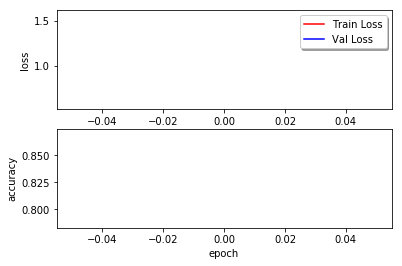

EPOCH: 2
TRAIN LOSS: 0.4949836702106129
VAL LOSS: 0.45745055497491094
VAL ACCURACY: 85.8 %
TIME: 210.1 s


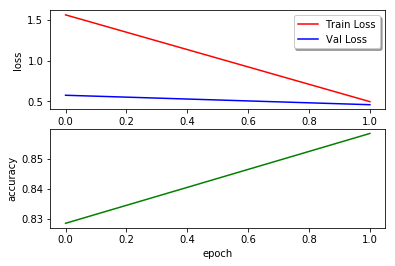

EPOCH: 3
TRAIN LOSS: 0.4260266311317423
VAL LOSS: 0.4290024032860089
VAL ACCURACY: 86.8 %
TIME: 577.1 s


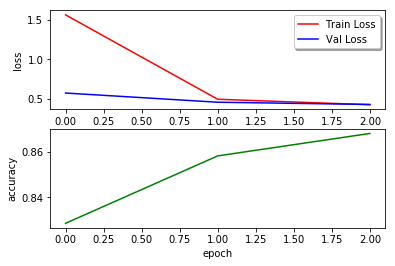

EPOCH: 4
TRAIN LOSS: 0.38472832089381703
VAL LOSS: 0.4066705407981469
VAL ACCURACY: 86.9 %
TIME: 278.8 s


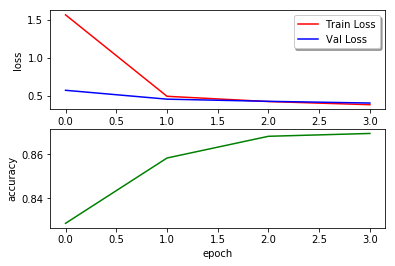

EPOCH: 5
TRAIN LOSS: 0.3514816939913367
VAL LOSS: 0.35189436079252256
VAL ACCURACY: 89.0 %
TIME: 201.1 s


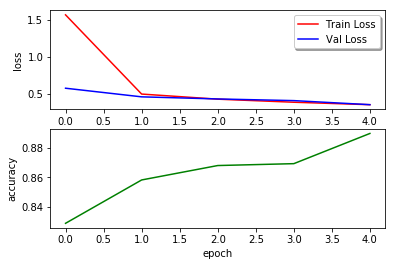

EPOCH: 6
TRAIN LOSS: 0.32128842166079297
VAL LOSS: 0.3408430980894276
VAL ACCURACY: 88.8 %
TIME: 205.4 s


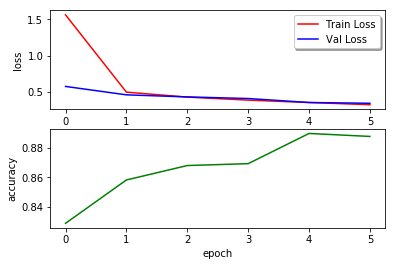

EPOCH: 7
TRAIN LOSS: 0.3053914720567301
VAL LOSS: 0.30184911559291683
VAL ACCURACY: 90.2 %
TIME: 200.7 s


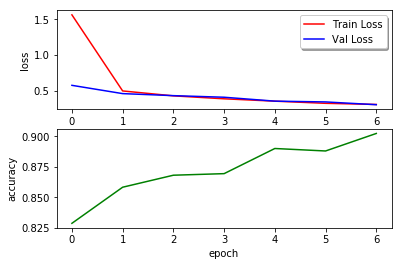

EPOCH: 8
TRAIN LOSS: 0.2822029094234642
VAL LOSS: 0.2952801176887985
VAL ACCURACY: 90.6 %
TIME: 201.4 s


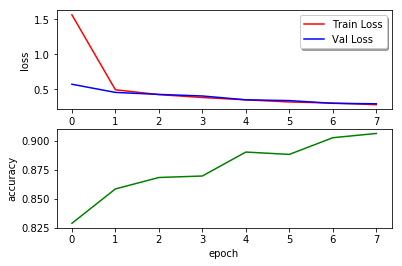

EPOCH: 9
TRAIN LOSS: 0.26983809094326106
VAL LOSS: 0.2999553627840876
VAL ACCURACY: 90.5 %
TIME: 200.7 s


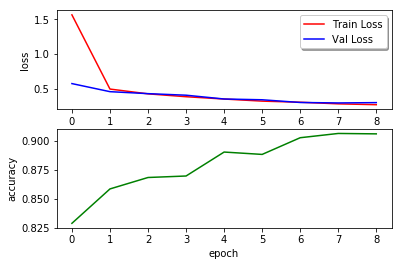

EPOCH: 10
TRAIN LOSS: 0.25244587769364485
VAL LOSS: 0.2732346322954551
VAL ACCURACY: 91.5 %
TIME: 201.0 s


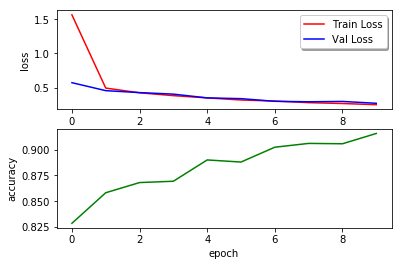

EPOCH: 11
TRAIN LOSS: 0.23963445263762953
VAL LOSS: 0.24558961223895537
VAL ACCURACY: 92.5 %
TIME: 209.4 s


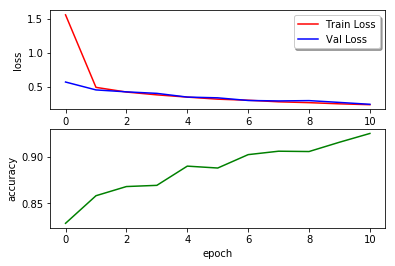

EPOCH: 12
TRAIN LOSS: 0.22400873608038474
VAL LOSS: 0.23450328127310371
VAL ACCURACY: 92.7 %
TIME: 611.8 s


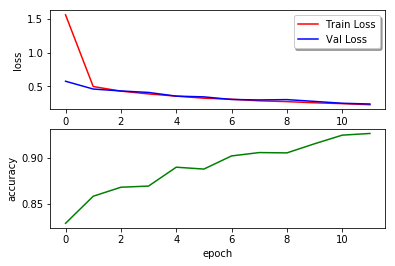

EPOCH: 13
TRAIN LOSS: 0.21459917363430245
VAL LOSS: 0.23378193946375528
VAL ACCURACY: 92.9 %
TIME: 1061.0 s


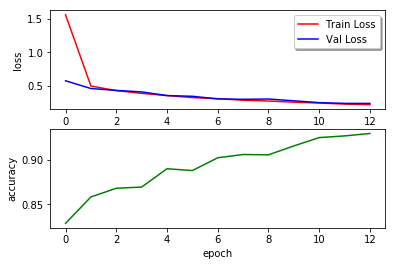

EPOCH: 14
TRAIN LOSS: 0.20615292464717558
VAL LOSS: 0.217019473430628
VAL ACCURACY: 93.1 %
TIME: 1062.6 s


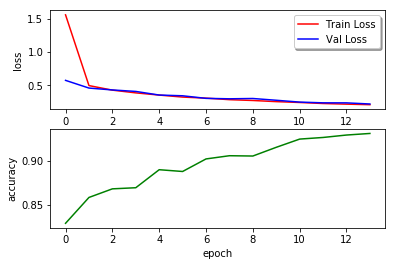

EPOCH: 15
TRAIN LOSS: 0.19687201613943173
VAL LOSS: 0.21062757859627018
VAL ACCURACY: 93.8 %
TIME: 290.9 s


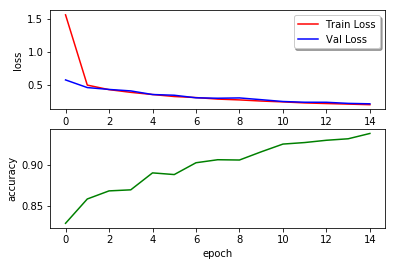

EPOCH: 16
TRAIN LOSS: 0.19035873483292656
VAL LOSS: 0.20602204374107422
VAL ACCURACY: 93.8 %
TIME: 219.8 s


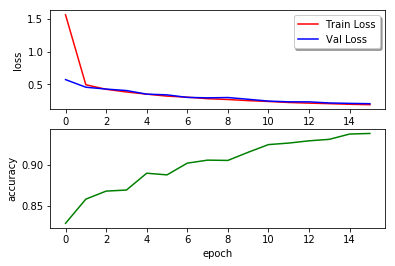

EPOCH: 17
TRAIN LOSS: 0.18282673374937347
VAL LOSS: 0.20039443037957075
VAL ACCURACY: 93.8 %
TIME: 219.9 s


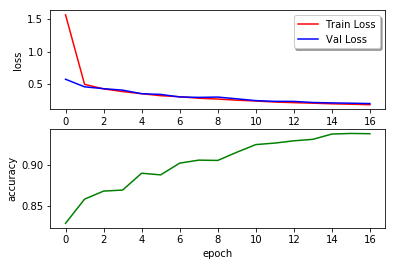

EPOCH: 18
TRAIN LOSS: 0.17597486070155105
VAL LOSS: 0.19695721949688122
VAL ACCURACY: 93.9 %
TIME: 222.5 s


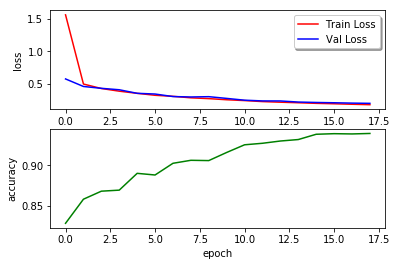

EPOCH: 19
TRAIN LOSS: 0.17004805690305047
VAL LOSS: 0.18815028803002742
VAL ACCURACY: 94.3 %
TIME: 223.4 s


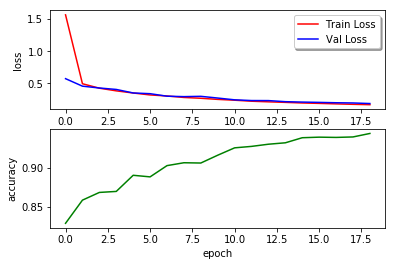

EPOCH: 20
TRAIN LOSS: 0.16632276774166097
VAL LOSS: 0.19487843766296375
VAL ACCURACY: 94.1 %
TIME: 226.1 s


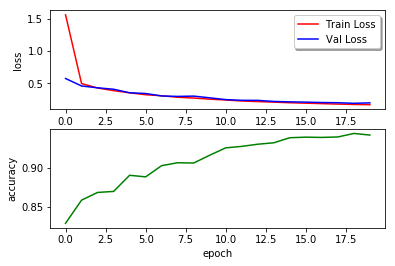

EPOCH: 21
TRAIN LOSS: 0.16060554378441774
VAL LOSS: 0.18646928546786543
VAL ACCURACY: 94.3 %
TIME: 225.0 s


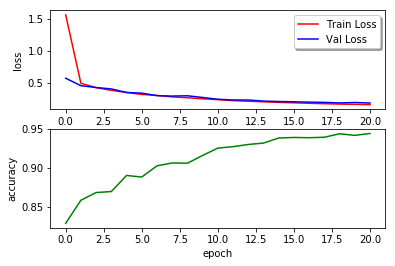

EPOCH: 22
TRAIN LOSS: 0.15493934536221263
VAL LOSS: 0.176196785204909
VAL ACCURACY: 94.8 %
TIME: 223.2 s


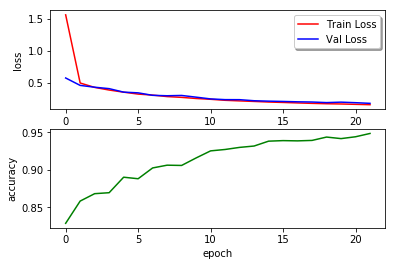

EPOCH: 23
TRAIN LOSS: 0.1520672235283649
VAL LOSS: 0.1824169782324511
VAL ACCURACY: 94.4 %
TIME: 227.5 s


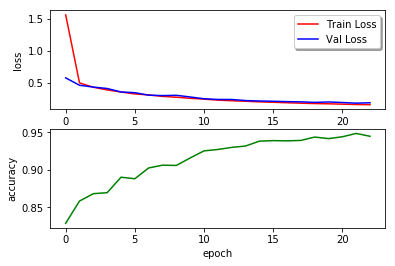

EPOCH: 24
TRAIN LOSS: 0.14723043013520346
VAL LOSS: 0.17820496377886916
VAL ACCURACY: 94.7 %
TIME: 229.6 s


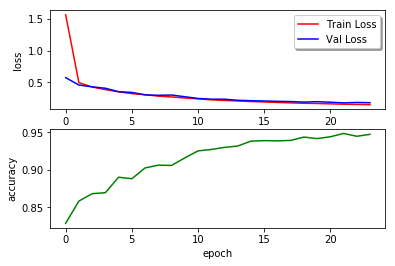

EPOCH: 25
TRAIN LOSS: 0.1441938923157349
VAL LOSS: 0.16409458418824047
VAL ACCURACY: 95.0 %
TIME: 225.6 s


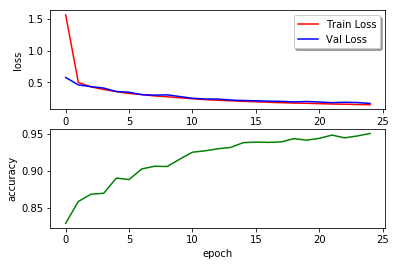

EPOCH: 26
TRAIN LOSS: 0.1384133106385483
VAL LOSS: 0.17049342494822606
VAL ACCURACY: 94.8 %
TIME: 226.8 s


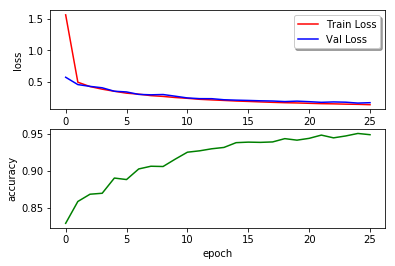

EPOCH: 27
TRAIN LOSS: 0.13720174327074572
VAL LOSS: 0.16654582551145114
VAL ACCURACY: 95.0 %
TIME: 230.0 s


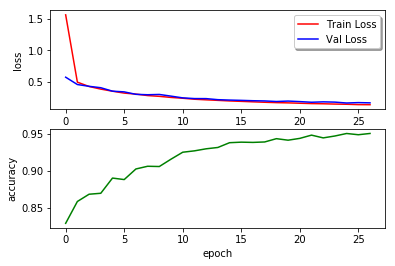

EPOCH: 28
TRAIN LOSS: 0.13504050879402293
VAL LOSS: 0.17284247978782455
VAL ACCURACY: 94.8 %
TIME: 231.1 s


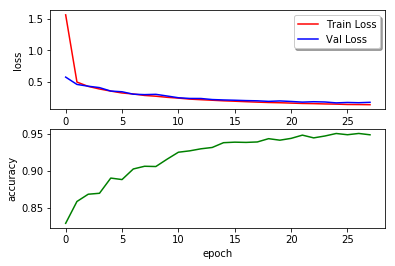

EPOCH: 29
TRAIN LOSS: 0.13237117814092345
VAL LOSS: 0.16337012470049242
VAL ACCURACY: 95.4 %
TIME: 232.9 s


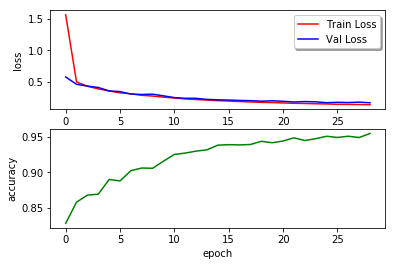

EPOCH: 30
TRAIN LOSS: 0.13018927785615297
VAL LOSS: 0.1575343811834575
VAL ACCURACY: 95.5 %
TIME: 237.9 s


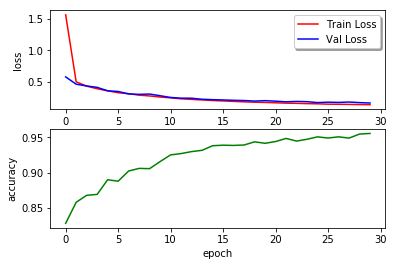

EPOCH: 31
TRAIN LOSS: 0.12700089515306695
VAL LOSS: 0.16575872524258706
VAL ACCURACY: 95.2 %
TIME: 348.7 s


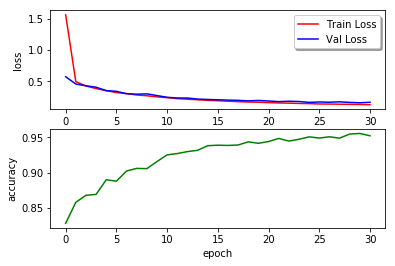

EPOCH: 32
TRAIN LOSS: 0.12295262810028082
VAL LOSS: 0.16663726125071476
VAL ACCURACY: 95.4 %
TIME: 238.7 s


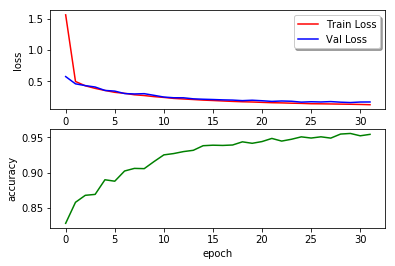

EPOCH: 33
TRAIN LOSS: 0.122764372045168
VAL LOSS: 0.16051518238790163
VAL ACCURACY: 95.4 %
TIME: 241.7 s


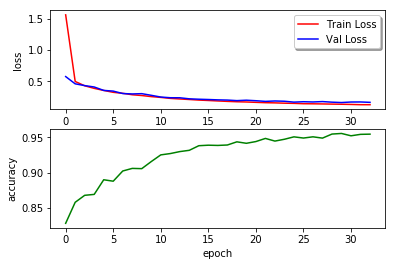

EPOCH: 34
TRAIN LOSS: 0.11922734354743646
VAL LOSS: 0.15830173529326416
VAL ACCURACY: 95.5 %
TIME: 465.1 s


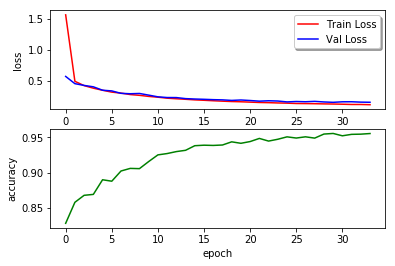

EPOCH: 35
TRAIN LOSS: 0.115695022710807
VAL LOSS: 0.1603834457596323
VAL ACCURACY: 95.4 %
TIME: 857.1 s


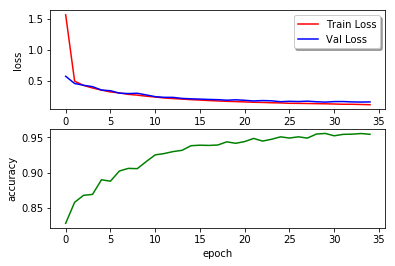

EPOCH: 36
TRAIN LOSS: 0.116462460246327
VAL LOSS: 0.16018913875209312
VAL ACCURACY: 95.3 %
TIME: 280.9 s


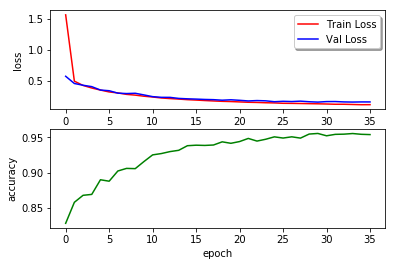

EPOCH: 37
TRAIN LOSS: 0.11348649169603764
VAL LOSS: 0.16283702661258928
VAL ACCURACY: 95.4 %
TIME: 380.5 s


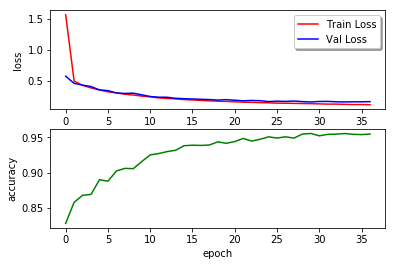

EPOCH: 38
TRAIN LOSS: 0.11268045017902428
VAL LOSS: 0.1540114240192962
VAL ACCURACY: 95.6 %
TIME: 291.5 s


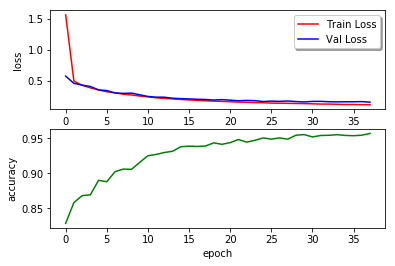

EPOCH: 39
TRAIN LOSS: 0.11059472491572625
VAL LOSS: 0.15984202724943786
VAL ACCURACY: 95.5 %
TIME: 377.9 s


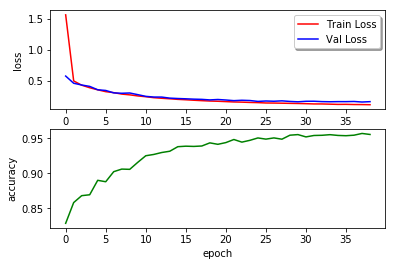

EPOCH: 40
TRAIN LOSS: 0.10870453979155116
VAL LOSS: 0.15925930562926685
VAL ACCURACY: 95.6 %
TIME: 270.5 s


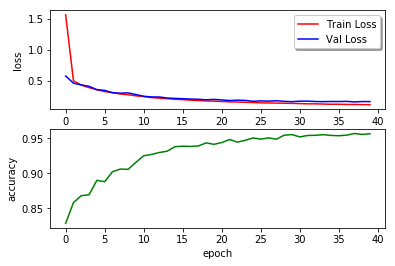

EPOCH: 41
TRAIN LOSS: 0.10561402760897563
VAL LOSS: 0.15944612694615354
VAL ACCURACY: 95.5 %
TIME: 374.3 s


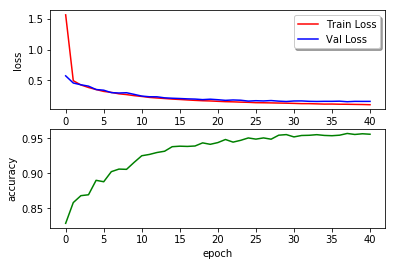

KeyboardInterrupt: 

In [11]:
import time
import sklearn
import numpy 
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,300):
 
    #start timer
    start = time.time()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
 
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
 
print ("TRAINING DONE!") 

In [10]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

cmatrix = []
cmatrix = np.zeros((7,7))
print(cmatrix) 

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


TypeError: Invalid dimensions for image data

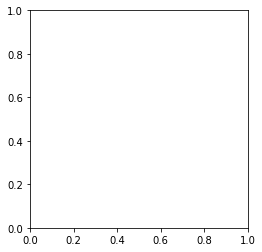

In [28]:
from sklearn.metrics import confusion_matrix
import itertools
 
################## CONFUSION MATRIX #####################
cmatrix = []
def clearConfusionMatrix():
 
    global cmatrix
 
    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((7,7))
    print(cmatrix)    

def updateConfusionMatrix(p, t):
 
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
 
def showConfusionMatrix():
 
    #new figure
    plt.figure(1)
    plt.clf()
 
    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
 
    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)
 
    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")
 
    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')
 
    #show
    plt.show()
    plt.pause(0.5)
    
showConfusionMatrix()
